<a href="https://colab.research.google.com/github/MohebZandi/Comupter_Vision/blob/main/Rewrite_CIFAR10_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rewriting the Autoencoders for CIFAR

In [1]:
# imoport libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# transformations
Ts = T.Compose([T.ToTensor(),
               T.Normalize([.5, .5, .5], [.5, .5, .5])
                ])

# importing data fom torchvision
train_data = torchvision.datasets.CIFAR10(root= './data', train= True, download= True, transform=Ts)
test_data = torchvision.datasets.CIFAR10(root= './data', train= False, download= True, transform=Ts)

# Creating DataLoaders
batchsize= 32
trainloader = DataLoader(train_data, batch_size= 32, shuffle= True, drop_last= True)
testloader = DataLoader(test_data, batch_size = 256)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(train_data.data.shape)
print(test_data.data.shape)
X0, y0 = next(iter(trainloader))
print(X0.data.shape)
print(y0.shape)

print(torch.min(X0.data), torch.max(X0.data))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
torch.Size([32, 3, 32, 32])
torch.Size([32])
tensor(-1.) tensor(1.)


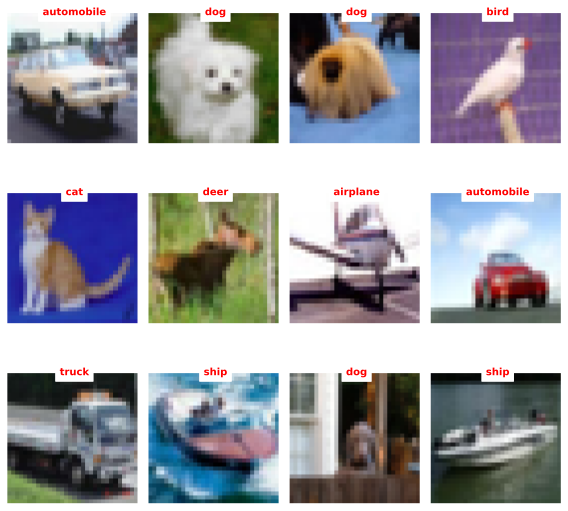

In [6]:
fig, axs = plt.subplots(3,4, figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):
    # extract that image (need to transpose it back to 32x32x3)
    pic = X0.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + 0.5       # Undo Normalization

    label = train_data.classes[y0[i]]

    ax.imshow(pic)
    ax.text(16, 0,label, ha= 'center', fontweight= 'bold', color = 'r', backgroundcolor = 'w')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Creating the NN Model

def makeNet(printornot= False):

    class AEnet(nn.Module):
        def __init__(self, printornot):
            super().__init__()

            self.print = printornot

            # encoding layer 1
            self.encoder1 = nn.Conv2d(3, 16, kernel_size= 4, stride= 2, padding= 1)

            # encoding layer 2
            self.encoder2 = nn.Conv2d(16, 32, kernel_size= 4, stride= 2, padding= 1)

            # encoding layer 3
            self.encoder3 = nn.Conv2d(32, 64, kernel_size= 4, stride= 2, padding= 1)

            # Decoder Layer 1
            self.decoder1 = nn.ConvTranspose2d(64, 32, kernel_size= 4, stride= 2, padding=1)

            # Decoder Layer 2
            self.decoder2 = nn.ConvTranspose2d(32, 16, kernel_size= 4, stride= 2, padding=1)

            # Decoder Layer 3
            self.decoder3 = nn.ConvTranspose2d(16, 3, kernel_size= 4, stride= 2, padding=1)


        # defining Forward function

        def forward(self, x):
            # Encoding forward
            if self.print: print(list(x.shape))
            x = F.leaky_relu(self.encoder1(x))
            if self.print: print(list(x.shape))
            x = F.leaky_relu(self.encoder2(x))
            if self.print: print(list(x.shape))
            x = F.leaky_relu(self.encoder3(x))

            if self.print: print(list(x.shape))


            # Decoding froward
            if self.print: print(list(x.shape))
            x = F.leaky_relu(self.decoder1(x))
            x = F.leaky_relu(self.decoder2(x))
            x = F.leaky_relu(self.decoder3(x))

            if self.print: print(list(x.shape))

            return x

    # Deifining the main function output
    net = AEnet(printornot)
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr= 0.001, weight_decay= 0.00001)

    return net, lossfun, optimizer 

In [13]:

# test the model with one batch
X, y = iter(trainloader).next()

print(X.data.shape)

netae , lossfunction, optim = makeNet(printornot= True)
yHat = netae(X)

print(lossfunction(yHat, X))

torch.Size([32, 3, 32, 32])
[32, 3, 32, 32]
[32, 16, 16, 16]
[32, 32, 8, 8]
[32, 64, 4, 4]
[32, 64, 4, 4]
[32, 3, 32, 32]
tensor(0.2985, grad_fn=<MseLossBackward0>)


In [28]:
# Creating a function to train the model
def trainmodel(net, lossfun, optimizer):

    numberepochs = 3

    net.to(device)

    trainloss = torch.zeros(numberepochs)
    testloss = torch.zeros(numberepochs)
    print('Number of epochs: %s'%numberepochs)
    print(' ')

    for epoch in range(numberepochs):
        
        net.train()
        batchloss = []

        for X,y in trainloader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfun(yHat, X)

            # Back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchloss.append(loss.item())
            # end of training in one epoch

        print('Training Epoch Number: ', epoch +1)
        trainloss[epoch] = np.mean(batchloss) 

        net.eval()
        batchloss = []
        
        for X,y in testloader:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, X)
            
            batchloss.append(np.mean(loss.item()))
            # end of testing in one epoch
        testloss[epoch] = np.mean(batchloss)
        print('Testing Epoch Number: ', epoch + 1)
        print ('Test loss is: ', testloss[epoch])
        print(' ')

        # End of epoch loop
    return trainloss, testloss


In [29]:
%%time
netAE , lossfunction, optimizer = makeNet(printornot= False)
trainingloss , testingloss = trainmodel(netAE, lossfunction, optimizer)

Number of epochs: 3
 
Training Epoch Number:  1
Testing Epoch Number:  1
Test loss is:  tensor(0.0311)
 
Training Epoch Number:  2
Testing Epoch Number:  2
Test loss is:  tensor(0.0236)
 
Training Epoch Number:  3
Testing Epoch Number:  3
Test loss is:  tensor(0.0206)
 
CPU times: user 1min 23s, sys: 744 ms, total: 1min 24s
Wall time: 1min 23s


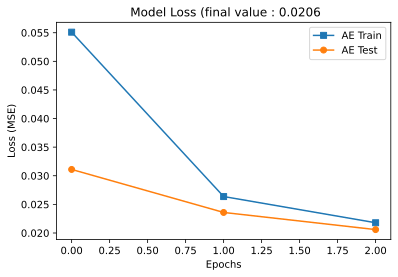

In [30]:
plt.plot(trainingloss, 's-', label= 'AE Train')
plt.plot(testingloss, 'o-', label= 'AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(' Model Loss (final value : %.4f'%testingloss[-1])
plt.legend()
plt.show()